In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

In [3]:
print(torch.__version__)

1.8.2


In [4]:
#Define File Path
# vec20avg_path = "./vec_data/vec20_avg.npz"
# vec25avg_path = "./vec_data/vec25_avg.npz"
vec30avg_path = "./vec_data/vec30_avg.npz"
# vec35avg_path = "./vec_data/vec35_avg.npz"
# vec20sum_path = "./vec_data/vec20_sum.npz"
# vec20sum_path = "./vec_data/vec20_sum.npz"
# vec25sum_path = "./vec_data/vec25_sum.npz"
vec30sum_path = "./vec_data/vec30_sum.npz"
# vec35sum_path = "./vec_data/vec35_sum.npz"
# freq_stance_labels = "./vec_data/freq_stance_labels.npz"
# oh_stance_labels = "./vec_data/oh_stance_labels.npz"
le_stance_labels = "./vec_data/le_stance_labels.npz"

In [5]:
def load_npz_file(filepath):
    # Load the numpy array from the .npz file
    with np.load(filepath, allow_pickle=True) as data:
        for key in data.keys():
            arr = data[key]
            break
    return arr

In [6]:
# vec20avg = load_npz_file(vec20avg_path)
# vec25avg = load_npz_file(vec25avg_path)
vec30avg = load_npz_file(vec30avg_path)
# vec35avg = load_npz_file(vec35avg_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec20sum = load_npz_file(vec20sum_path)
# vec25sum = load_npz_file(vec25sum_path)
vec30sum = load_npz_file(vec30sum_path)
# vec35sum = load_npz_file(vec35sum_path)
# freq_label = load_npz_file(freq_stance_labels)
# oh_label = load_npz_file(oh_stance_labels)
le_label = load_npz_file(le_stance_labels)

In [7]:
#指派實際要使用的Data與Label
# data = vec30avg
data = vec30sum
# label = np.argmax(oh_label, axis=1)
# label = oh_label
# label = freq_label
label = le_label

In [8]:
print(data.shape)
print(label.shape)
print(np.unique(label))
print(np.unique(label, return_counts=True))

(445, 1, 300)
(445,)
[0 1 2 3]
(array([0, 1, 2, 3]), array([ 11, 201,  74, 159], dtype=int64))


In [9]:
# Data Augmentation using Oversampling
# Define the oversampling ratio for each class
# oversample_ratio = {0: 100, 1: 201, 2: 120, 3: 159}
oversample_ratio = {0: 55, 1: 201, 2: 148, 3: 159}
# Initialize the oversampler
oversampler = RandomOverSampler(sampling_strategy=oversample_ratio)
# Reshape your data to a 2D matrix of shape (n_samples, n_features)
X = data.reshape(-1, 300)
# Apply oversampling to X and y
X_resampled, y_resampled = oversampler.fit_resample(X, label)
# Reshape X back to its original shape
X_resampled = X_resampled.reshape(-1, 1, 300)

In [10]:
print(X_resampled.shape)
print(X_resampled)

(563, 1, 300)
[[[-1.05289996 -1.29180002 10.12859917 ... -0.30050007  1.0638001
    0.92839986]]

 [[-0.92129999 -1.5751     10.76149985 ... -0.16209998  0.18860002
    1.30480001]]

 [[-1.47109997 -0.9589     12.55939994 ...  0.43750004  1.26569999
   -0.89280003]]

 ...

 [[-2.17210002 -1.2239     10.33119998 ... -0.18510005  0.13440002
   -0.01459999]]

 [[-1.42170001 -1.42719997 11.72809998 ... -0.12030001 -0.25129999
   -0.33050002]]

 [[-1.72440002  0.09580001 11.37470001 ... -1.60950002  1.78809998
   -0.1829    ]]]


In [11]:
print(y_resampled.shape)
print(y_resampled)

(563,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 2 1 2 1 2 1 2 2 1 2 2 2 1 1 2 1 1 1 1 1 2 1 1 2 2
 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1 1 1 2 2 1 2 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2
 1 1 2 1 1 1 2 2 2 2 1 1 2 1 1 2 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 1
 2 1 2 2 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2

In [12]:
# Using original data
# train_data, test_data, train_labels, test_labels = train_test_split(data, label, test_size=0.2)
# Using oversampling data
train_data, test_data, train_labels, test_labels = train_test_split(X_resampled, y_resampled, test_size=0.3)
print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

Train data shape: (394, 1, 300)
Train labels shape: (394,)
Test data shape: (169, 1, 300)
Test labels shape: (169,)


In [13]:
# Convert the data and labels to PyTorch tensors
train_data_tensor = torch.from_numpy(train_data).float()
train_labels_tensor = torch.from_numpy(train_labels).long()
test_data_tensor = torch.from_numpy(test_data).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

In [14]:
print(train_data_tensor.shape)
print(test_data_tensor.shape)
print(train_labels_tensor.shape)
print(test_labels_tensor.shape)

torch.Size([394, 1, 300])
torch.Size([169, 1, 300])
torch.Size([394])
torch.Size([169])


In [15]:
# Create a TensorDataset for each set of data and labels
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

In [16]:
# Create a DataLoader for each dataset to batch and shuffle the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Define the LSTM model architecture
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()   
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=0)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [18]:
# Trainging Settings
input_size = 300  # Size of input vector
hidden_size = 64  # Number of features in the hidden state
num_layers = 2  # Number of LSTM layers
output_size = 4  # Number of output classes
learning_rate = 0.001

# Instantiate the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
# Define Loss Function weights
# class_weights = torch.FloatTensor(weights).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights) # Using weight
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Epochs and records
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early Stopping Settings
# Define the number of epochs to wait before stopping if the test accuracy does not improve
patience = 3
# Initialize the counter for the number of epochs without improvement
counter = 0
# Initialize the best test accuracy to zero
best_val_accuracy = 0.0

# torchmetrcis settings
model_accuracy = MulticlassAccuracy(num_classes=4).to(device)
model_precision = MulticlassPrecision(num_classes=4).to(device)
model_recall = MulticlassRecall(num_classes=4).to(device)
model_f1 = MulticlassF1Score(num_classes=4).to(device)

In [19]:
# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    model.train()  
    # Iterate over batches of train data
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move inputs and labels to GPU if available
        data = data.to(device)
        target = target.squeeze().long().to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        loss = criterion(output, target) # Check this line
        # loss = criterion(output, target.squeeze().to(torch.long)) # Check this line
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Calculate metrics
        train_loss += loss.item() * data.size(0)
        # train_loss += loss.item() # Check this line
        _, predicted = torch.max(output, 1)
        # _, predicted = torch.max(output.data, 1) # Check this line
        train_correct += torch.sum(predicted == target.data)
        # train_correct += (predicted == target.squeeze().long()).sum().item() # Check this line

    train_loss /= len(train_loader)
    train_accuracy = 100.0 * train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Set model to evaluation mode
    model.eval()
    val_loss = 0.0
    val_correct = 0
    # Iterate over batches of validation data
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            # Move inputs and labels to GPU if available
            inputs = inputs.to(device)
            labels = labels.squeeze().long().to(device) 
            # Forward pass
            output = model(inputs)
            # loss = criterion(outputs, labels)
            loss = criterion(output, labels.squeeze().to(torch.long))
            # Calculate metrics
            val_loss += loss.item() * data.size(0)
            # val_loss += loss.item() # Check this line
            _, predicted = torch.max(output, 1)
            # _, predicted = torch.max(output.data, 1) # Check this line
            val_correct += torch.sum(predicted == labels.data)
            # val_correct += (predicted == target.squeeze().long()).sum().item() # Check this line
            model_accuracy.update(predicted, labels.squeeze().long())
            model_precision.update(predicted, labels.squeeze().long())
            model_recall.update(predicted, labels.squeeze().long())
            model_f1.update(predicted, labels.squeeze().long())
        val_loss /= len(test_loader)
        val_accuracy = 100.0 * val_correct / len(test_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
 
    # Print metrics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, epoch, train_loss, train_accuracy, val_loss, val_accuracy))
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch", epoch)
            break

Epoch [1/0], Train Loss: 41.5831, Train Acc: 33.2487, Val Loss: 13.0995, Val Acc: 40.2367
Epoch [2/1], Train Loss: 38.7601, Train Acc: 34.7716, Val Loss: 11.8777, Val Acc: 56.2130
Epoch [3/2], Train Loss: 33.8930, Train Acc: 64.2132, Val Loss: 10.2417, Val Acc: 73.3728
Epoch [4/3], Train Loss: 27.6346, Train Acc: 79.9492, Val Loss: 8.2641, Val Acc: 81.0651
Epoch [5/4], Train Loss: 20.7233, Train Acc: 84.5178, Val Loss: 6.5277, Val Acc: 81.0651
Epoch [6/5], Train Loss: 14.1319, Train Acc: 89.0863, Val Loss: 5.9317, Val Acc: 81.0651
Epoch [7/6], Train Loss: 10.0613, Train Acc: 91.8782, Val Loss: 4.5680, Val Acc: 83.4320
Epoch [8/7], Train Loss: 6.8249, Train Acc: 95.1777, Val Loss: 4.7764, Val Acc: 82.8402
Epoch [9/8], Train Loss: 5.1584, Train Acc: 96.1929, Val Loss: 4.1073, Val Acc: 84.0237
Epoch [10/9], Train Loss: 3.5943, Train Acc: 97.9695, Val Loss: 4.2774, Val Acc: 82.8402


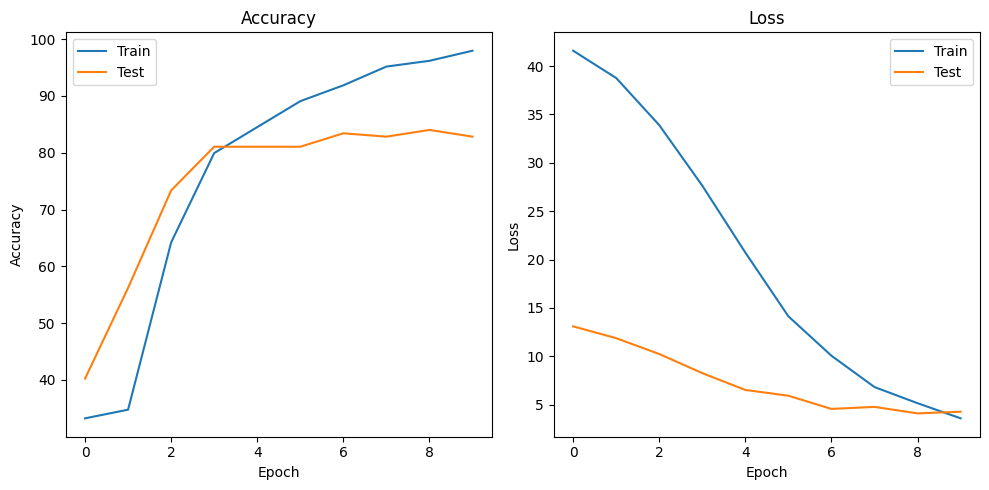

In [20]:
# Plot the train and test accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(train_accuracies, label='Train')
ax1.plot(val_accuracies, label='Test')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(train_losses, label='Train')
ax2.plot(val_losses, label='Test')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.savefig('vec30_sum_lstm_230418.PNG', dpi=300)
plt.show()

In [ ]:
#Save Model Parameter
# torch.save(model, 'lstm_vec30sum.pt')

In [21]:
ac = model_accuracy.compute()
pc = model_precision.compute()
rc = model_recall.compute()
f1 = model_f1.compute()
print('Accuracy: {:.2%}'.format(ac.item()))
print('Precision: {:.2%}'.format(pc.item()))
print('Recall: {:.2%}'.format(rc.item()))
print('F1-score: {:.2%}'.format(f1.item()))

Accuracy: 75.80%
Precision: 79.79%
Recall: 75.80%
F1-score: 76.76%


# Calculate LSTM F1-Score
https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html